In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE
from torch import distributions

In [3]:
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model11 = architecture.base(num_classes=10, **architecture.kwargs)
model12 = architecture.base(num_classes=10, **architecture.kwargs)
m = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve3/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve4/checkpoint-30.pt')['model_state'])

In [4]:
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

You are going to run models on the test set. Are you sure?


In [5]:
def distance(model1, model2):
    par1 = np.concatenate([p.data.cpu().numpy().ravel() for p in model1.parameters()])
    par2 = np.concatenate([p.data.cpu().numpy().ravel() for p in model2.parameters()])
    u = par2 - par1
    dx = np.linalg.norm(u)
    return dx

In [6]:
# ind = 1
# T = True
# S = []
# B = []
# while ind<20:

#     ckpt = 'curves_mnist/LinearOneLayer/LongTraining/curve'+str(ind)+'/checkpoint-30.pt'
#     checkpoint = torch.load(ckpt)
#     m.load_state_dict(checkpoint['model_state'])
    
#     S.append(samples(m))
#     B.append(list(m.parameters())[-1].data.numpy())
#     ind+=1
    
# S = np.concatenate(S)

## Flow Generator 

In [167]:
class BatchNorm(nn.Module):
    def __init__(self, dim_in):
        super(BatchNorm, self).__init__()

        self.mu = torch.zeros(dim_in).cuda()
        self.sig2 = torch.zeros(dim_in).cuda()+0.1
        self.momentum=0.1
        
    def forward(self, x):

        if self.training:
            mu = x.mean(0)
            sig2 = (x-mu).pow(2).mean(0)  
            x = (x-mu)/(sig2 + 1.0e-6 ).sqrt()
            self.mu = self.momentum*mu + (1-self.momentum)*self.mu
            self.sig2 =  self.momentum*sig2 + (1-self.momentum)*self.sig2
            return x, sig2+1.0e-6 
        else: 
            x = (x-self.mu)/(self.sig2+1.0e-6).sqrt()
            return x, self.sig2+1.0e-6 
        
        
class SNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNet, self).__init__()
        affine = True
        self.h = nn.Tanh() #nn.LeakyReLU() #nn.Tanh()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
#         x = torch.clamp(x, -1, 1) 
        return x
    
class TNet(nn.Module):
    def __init__(self,  dim_in, dim_middle):
        super(TNet, self).__init__()
        affine = True
        self.h = nn.Tanh()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x


In [168]:
import numpy as np
N_layers = 1
n_dim = 795
onezero = [0, 1]*n_dim
masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
masks = masks.view(2*N_layers, -1)
len(masks), masks.shape

(2, torch.Size([2, 795]))

In [238]:
class RealNVP(nn.Module):
    def __init__(self, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior 
        self.mask = nn.Parameter(mask, requires_grad=False).cuda()
        self.t = torch.nn.ModuleList([SNet(dim_in=795, dim_middle=795*2) for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([TNet(dim_in=795, dim_middle=795*2) for _ in range(len(mask))])
        self.b = torch.nn.ModuleList([BatchNorm(dim_in=795) for _ in range(len(mask))])
        self.batch_norm = True
        self.verbose = False
        
        
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        self.in_dim = n_dim
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)

        
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        for i, (s, t, b) in enumerate(zip(reversed(self.s), reversed(self.t), reversed(self.b))):
            m = self.mask[-i-1]
#             print('i', i, 'm', m)
            
            if self.verbose:
                print('z1', z)
            z = (m*z +(1-m)*(z-t(m*z))*(-s(m*z)).exp()).detach()
#             print('z1', z)
            if self.batch_norm:
                z = (z*(b.sig2+1.0e-6).sqrt()+b.mu).detach()
            if self.verbose:
                print('z2', z)
        
        x = z
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        for s, t, m, b in zip(self.s, self.t, self.mask, self.b):

            if self.batch_norm:
                z, sig2 = b(z)
#             print(m.shape, z.shape)
            s_res = s(m*z)
            z = m*z +(1-m)*(z*s_res.exp()+t(m*z))
           
            if self.batch_norm:
                log_det_J += ((1-m)*s_res-0.5*sig2.log()).sum(-1)
            else:
                log_det_J += ((1-m)*s_res).sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        
#         logp = -0.5*np.log(np.pi*2)-0.5*z.pow(2)
#         logp = logp.sum(-1)
#         logp = self.prior.log_prob(z)
        logp = self.prior.log_prob(z.cpu()).cuda()
#         shape = torch.Size((K, self.in_dim))
#         logp = torch.cuda.FloatTensor(x.shape[0])
#         self.prior.log_prob(z.cpu(), out=logp)
        
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         print('logp', logp.shape)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)

        shape = torch.Size((K, 795))
        e = torch.cuda.FloatTensor(shape)
        torch.randn(shape, out=e)   
#         e = (1/2000)*e
#         e[:, :785] = (1/28)*e[:, :785]
#         e[:, 785:] = (1/np.sqrt(2000))*e[:, 785:]
#         e = (self.mean + self.A(e))   
        x = self.f(e)[0]
#         x = self.g(e)
        
#         z = self.prior.sample((K, )).cuda()
#         x = self.g(z)
        
        return x

In [256]:
class Gaussian_Flow(nn.Module):
    def __init__(self, n_dim=795, N_layers=10):
        super(Gaussian_Flow, self).__init__()
        
        onezero = [0, 1]*n_dim
        masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
        masks = masks.view(2*N_layers, -1)
        print('masks', masks, masks.shape)
        prior = distributions.MultivariateNormal(torch.zeros(n_dim), torch.eye(n_dim))
        
        self.nvp = RealNVP(masks, prior)
        self.relu = nn.ReLU()
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, ))).cuda()
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)
        
        self.verbose = False
        self.l2 = 0

    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        W = self.nvp.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        if self.verbose:
            print('x', x.shape)
            print('W1', W1.shape)
            print('b1', b1.shape)
            
        x = F.linear(x, W1, b1[:, 0])
        
        if self.verbose:
            print('x', x.shape)
            print(x.shape)
            
        x = self.relu(x)

        x = F.linear(x, W2, self.b2) 
#         x = 1/K*x
        
        if self.verbose:
            print(x.shape)
        
#         print(W1.shape, b1.shape)
        self.l2 = W1.pow(2).sum()+W2.pow(2).sum() +b1.sum(-1).pow(2).sum()
#         print(self.L2)
            
        return x

In [257]:
GF = Gaussian_Flow(n_dim=795, N_layers=1)

masks tensor([[0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.]]) torch.Size([2, 795])


In [263]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, GF.parameters()),
    lr=1e-5,
)

In [264]:
GF.cuda();

In [265]:
def l2_regularizer(weight_decay):
    return lambda model: 0.5 * weight_decay * GF.l2

In [266]:
regularizer = l2_regularizer(1e-4)

In [267]:
columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    train_res = utils.train(loaders['train'], GF, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], GF, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)
#     test_flow(model1, model2, GF, N=2000)

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0    46.8448    51.8517     2.2464    53.5900    21.0392
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1    44.7431    56.1950     1.8373    59.5700    21.0512
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   2    43.8603    62.5450     1.4306    66.6600    21.1004
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   3    43.2576    66.7733     1.3396    68.4200    21.1063
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   4    42.8129    70.0117     1.1611    71.0400    21.1465
  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  -

In [272]:
def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

def get_model(W, B):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = W.cpu().data.numpy()
    SIZE = 2000

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         if size == 10:
#             value = 1/2000*value
#         else:
#             value = value
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(torch.from_numpy(B.mean(0)))
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def test_flow(model1, model2, flow, N=2000):
    
#     rcParams['figure.figsize'] = 12, 10
#     rcParams['figure.dpi'] = 100

    flow.cuda()
    flow.eval()
#     print('copmuting samples...')
#     X = torch.FloatTensor(S[:N]).cuda()
#     X_sample = X.data.cpu().numpy()
#     X_prior = prior.sample((N,)).cpu().data.numpy()
#     X_flow = flow.sample(N, ).data.cpu().numpy()
#     X_sample_prior = flow.f(torch.FloatTensor(X_sample).cuda())[0].data.cpu().numpy()
    
#     print('drawing...')
#     i, j = 500, -1
#     fig, axes = plt.subplots(2, 2,)
#     axes[0, 0].set_title('Samples')
#     axes[0, 0].scatter(X_sample[:, i], X_sample[:, j])
#     axes[0, 1].set_title('Prior')
#     axes[0, 1].scatter(X_prior[:, i], X_prior[:, j])
#     axes[1, 0].set_title('Flow sampling')
#     axes[1, 0].scatter(X_flow[:, i], X_flow[:, j])
#     axes[1, 1].set_title('Map from samples to prior')
#     axes[1, 1].scatter(X_sample_prior[:, i], X_sample_prior[:, j]) 
#     plt.show()
    
    print('computing Arc model...')
    W1 = samples(model1)
    W2 = samples(model2)
    
#     W1[:, 785:] = 2000*W1[:, 785:]
#     W2[:, 785:] = 2000*W2[:, 785:]
    
#     flow.cpu()
    W_pre = 1/np.sqrt(2)*flow.nvp.g(torch.FloatTensor(W1).cuda())+1/np.sqrt(2)*flow.nvp.g(torch.FloatTensor(W2).cuda())
    W = flow.nvp.f(W_pre)[0]
#     W[:, 785:] = 1/2000*W[:, 785:]
    B = []
    B.append(list(model1.parameters())[-1].data.cpu().numpy())
    B.append(list(model2.parameters())[-1].data.cpu().numpy())
    B = np.array(B)
    
#     model_sampled = get_model(torch.tensor(W1).cuda(), B)
#     test(model_sampled)
    
    model_sampled = get_model(W, B)
    test(model_sampled)
    

    
    if N==2000:
        print('computing Sampling from flow model...')
        
        B = []
        B.append(flow.b2.data.cpu().numpy())
        B = np.array(B)
    
        X_flow = flow.nvp.sample(N, ).data.cpu()
#         X_flow[:, :784] = X_flow[:, :784]
#         X_flow[:, 785:] = 1/2000*X_flow[:, 785:]
        model_flow = get_model(X_flow, B)
        test(model_flow)
#         return model_sampled, model_flow
    
#     return model_sampled
    

In [273]:
test_flow(model1, model2, GF, N=2000)

computing Arc model...
{'nll': 0.043516448573271437, 'loss': 0.043516448573271437, 'accuracy': 98.98666666666666}
{'nll': 0.07036074814796447, 'loss': 0.07036074814796447, 'accuracy': 97.92}
{'nll': 894916328.7168, 'loss': 894916328.7168, 'accuracy': 16.58}
{'nll': 731623296.3848, 'loss': 731623296.3848, 'accuracy': 16.82}
computing Sampling from flow model...
{'nll': 0.8460212607701619, 'loss': 0.8460212607701619, 'accuracy': 79.60833333333333}
{'nll': 0.8191173463821411, 'loss': 0.8191173463821411, 'accuracy': 79.87}


## Trainig mean and covariance matrix One hidden layer

In [74]:
class Gaussian_model(nn.Module):
    def __init__(self, n_dim=795):
        super(Gaussian_model, self).__init__()
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        self.in_dim = n_dim
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, )))
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)

    def sample(self, K, cuda=True):
        
        if cuda:
            shape = torch.Size((K, self.in_dim))
            e = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=e)   
        else:          
            e = torch.randn((K, self.in_dim))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=2000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        x = F.linear(x, W1, b1[:, 0])
        x = self.relu(x)
        x = F.linear(x, W2, self.b2) 
        x = 1/K*x

        return x

In [75]:
GM = Gaussian_model()
GM.cuda();

masks tensor([[0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.]]) torch.Size([2, 795])


In [76]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.Adam(
    filter(lambda param: param.requires_grad, GM.parameters()),
    lr=1e-4,
#     momentum=0.9,
)

In [77]:
columns = ['ep', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()


    train_res = utils.train(loaders['train'], GM, optimizer, criterion, regularizer, cuda=True)
    test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)

    time_ep = time.time() - time_ep
    values = [epoch, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fc91755f730>
Traceback (most recent call last):
  File "/home/anokhin/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/home/anokhin/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   0     0.4760    85.6850     0.3189    90.9500    17.9283


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fc91755f730>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anokhin/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
    self._shutdown_workers()
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/anokhin/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
    self.worker_result_queue.close()
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/home/anokhin/anacon

  ep    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------
   1     0.3574    90.4917     0.2769    91.7400    18.0539


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7fc91755f730>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/anokhin/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
    self._shutdown_workers()
  File "/home/anokhin/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
  File "/home/anokhin/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 704, in _shutdown_workers
OSError: [Errno 9] Bad file descriptor
    self.worker_result_que

RuntimeError: DataLoader worker (pid 32204) is killed by signal: Aborted. 

In [884]:
# GM(X)[0]

In [887]:
# test_res = utils.test(loaders['test'], GM, criterion, regularizer, cuda=True)
# test_res

In [260]:
samples = GM.sample(2000).data.numpy()
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


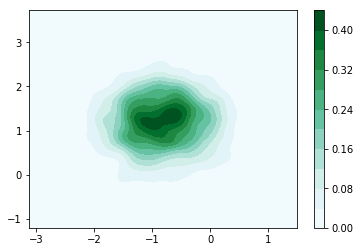

In [264]:
sns.kdeplot(samples[:, 0], samples[:, 70], shade=True,  cbar=True)

In [277]:
X_embeddeds = TSNE(n_components=2).fit_transform(samples)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


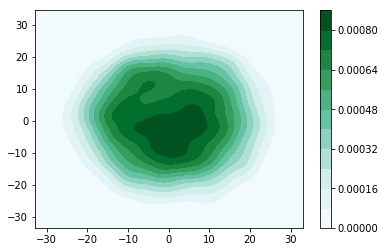

In [279]:
sns.kdeplot(X_embeddeds[:, 0], X_embeddeds[:, 1], shade=True,  cbar=True)

## Trainig mean and covariance matrix Several hidden layer

In [249]:
class GMMultyLayer(nn.Module):
    def __init__(self, n_dim=809):
        super(GMMultyLayer, self).__init__()
        self.n_dim = n_dim
        self.A = nn.Linear(n_dim, n_dim)
        self.relu = nn.ReLU()
        data_mean = torch.FloatTensor(np.random.normal(size=(n_dim, )))
        self.mean= nn.Parameter(data = data_mean, requires_grad=True)
        
        data_bf = torch.FloatTensor(np.random.normal(size=(10, )))
        self.bf = nn.Parameter(data = data_bf, requires_grad=True)

    def sample(self, K):
        e = torch.randn((K, self.mean.size()[0]))
        W = (self.mean + self.A(e))       
        return W
    

    def forward(self, x, K=4000):

        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784]
        
        W2 = W[:, 785]
        b2 = W[:, 786]
        Wf =  W[:, -10:].transpose(0,1)
        
        x = F.linear(x, W1, b1)
        x = self.relu(x)
        for i in range(int(self.n_dim-784-10/2), 2):
            Wi = W[:, 785+i]
            bi = W[:, 786+i]
            x = self.relu(Wi*x+bi)
            
        x = F.linear(x, Wf, self.bf) 
        x = 1/K*x
#         print(x.shape)
        return x

In [250]:
GML = GMMultyLayer()

In [251]:
criterion = F.cross_entropy
regularizer = None 
optimizer = torch.optim.SGD(
    filter(lambda param: param.requires_grad, GML.parameters()),
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0
)

In [252]:
columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_nll', 'te_acc', 'time']
for epoch in range(0, 10 + 1):
    time_ep = time.time()

    lr = 1e-3
    utils.adjust_learning_rate(optimizer, lr)

    train_res = utils.train(loaders['train'], GML, optimizer, criterion, regularizer)
    test_res = utils.test(loaders['test'], GML, criterion, regularizer)

    time_ep = time.time() - time_ep
    values = [epoch, lr, train_res['loss'], train_res['accuracy'], test_res['nll'],
              test_res['accuracy'], time_ep]

    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
    print(table)

  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   0     0.0010     2.7916    14.3017     2.2235    14.8000    93.5746
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   1     0.0010     2.1833    15.8317     2.1439    18.0300    91.0075
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   2     0.0010     2.0937    24.0500     2.0191    30.7600    90.9785
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   3     0.0010     1.9095    36.9383     1.7213    47.6100    90.6315
  ep         lr    tr_loss     tr_acc     te_nll     te_acc       time
----  ---------  ---------  ---------  ---------  ---------  ---------
   4  